<a href="https://colab.research.google.com/github/NatthasitTobua/Identify_the_Sentiments/blob/main/Identify_the_Sentiments.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
 from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install transformers
!pip install cloud-tpu-client==0.10 https://storage.googleapis.com/tpu-pytorch/wheels/torch_xla-1.9-cp37-cp37m-linux_x86_64.whl

     |████████████████████████████████| 2.9 MB 5.5 MB/s 
     |████████████████████████████████| 3.3 MB 33.9 MB/s 
     |████████████████████████████████| 56 kB 4.6 MB/s 
     |████████████████████████████████| 636 kB 75.1 MB/s 
     |████████████████████████████████| 895 kB 70.9 MB/s 
     |████████████████████████████████| 109 kB 57.6 MB/s 
     |████████████████████████████████| 546 kB 63.1 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
     |████████████████████████████████| 149.9 MB 28 kB/s 
     |████████████████████████████████| 57 kB 2.7 MB/s 
  Attempting uninstall: google-api-python-client
    Found existing installation: google-api-python-client 1.12.8
    Uninstalling google-api-python-client-1.12.8:
      Successfully uninstalled google-api-python-client-1.12.8
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. 

In [3]:
import warnings
import torch_xla
import torch_xla.distributed.parallel_loader as pl
import torch_xla.core.xla_model as xm
import torch_xla.distributed.xla_multiprocessing as xmp
import warnings

import re
import os
import time

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from transformers import BertTokenizerFast as BertTokenizer, BertModel, AdamW, get_linear_schedule_with_warmup, RobertaModel, RobertaTokenizer

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, classification_report, roc_curve

In [4]:
device = xm.xla_device()

In [5]:
train = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/NLP/train.csv")
test = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/NLP/test.csv")
ss = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/NLP/sample_submission.csv")

In [6]:
print('train data has', train.shape[0], 'rows')
print('test data has', test.shape[0], 'rows')

train data has 7920 rows
test data has 1953 rows


In [7]:
train.head(3)

,id,label,tweet
0,1,0,#fingerprint #Pregnancy Test https://goo.gl/h1...
1,2,0,Finally a transparant silicon case ^^ Thanks t...
2,3,0,We love this! Would you go? #talk #makememorie...


**EXPLORING DATA**

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


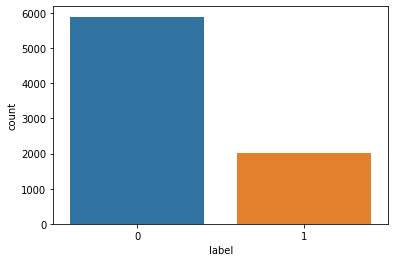

In [8]:
#see how many labels in each category
sns.countplot(train['label'])

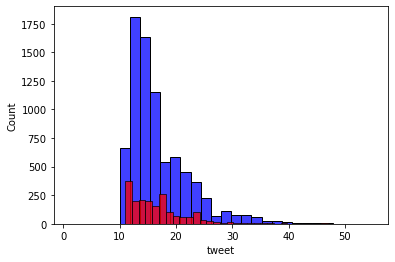

In [9]:
#plot lenght of tweet
sns.histplot(train['tweet'].apply(lambda x: len(x.split())), bins = 30, color = 'blue')
sns.histplot(test['tweet'].apply(lambda x: len(x.split())), bins = 30, color = 'red')

In [10]:
#average length of text
print('train average length :',train['tweet'].apply(lambda x: len(x.split())).mean())
print('test average length :',test['tweet'].apply(lambda x: len(x.split())).mean())

train average length : 16.843434343434343
test average length : 16.872503840245777


In [11]:
def cleaned_tweet(doc):
  # remove links and non-ASCII characters
  url = re.compile(r'https?://\S+|www\.\S+')
  doc = url.sub('',doc)

  # lower case and remove special characters\whitespaces
  doc = re.sub(r'[^a-zA-Z\s]', '', doc, re.I|re.A)
  doc = doc.lower()
  doc = doc.strip()
  
  return doc

In [12]:
train['cleaned_tweet'] = train['tweet'].apply(lambda x : cleaned_tweet(x))
test['cleaned_tweet'] = test['tweet'].apply(lambda x : cleaned_tweet(x))

In [13]:
train.head(3)

,id,label,tweet,cleaned_tweet
0,1,0,#fingerprint #Pregnancy Test https://goo.gl/h1...,fingerprint pregnancy test android apps beaut...
1,2,0,Finally a transparant silicon case ^^ Thanks t...,finally a transparant silicon case thanks to ...
2,3,0,We love this! Would you go? #talk #makememorie...,we love this would you go talk makememories un...


In [14]:
np.argmax(train['tweet'].apply(lambda x: len(x.split())))

1794

In [15]:
print(train['tweet'][1794])
print(train['cleaned_tweet'][1794])

¿Me lo dices o me lo preguntas #Apple ? Ya mi teléfono funciona solo conectado a la electricidad. Do you tell me or do yo ask me #apple ? Now my iPhone works only connected.Have you asked yourself if you were in a bad economic situation could you pay a new phone? #apple https://twitter.com/el_interes/status/944881090115899392 …
me lo dices o me lo preguntas apple  ya mi telfono funciona solo conectado a la electricidad do you tell me or do yo ask me apple  now my iphone works only connectedhave you asked yourself if you were in a bad economic situation could you pay a new phone apple


**MODEL**

In [16]:
#use pretrained model 
model_name = 'roberta-base'
tokenizer = RobertaTokenizer.from_pretrained(model_name)

Downloading:   0%|          | 0.00/878k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.29M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/481 [00:00<?, ?B/s]

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


(0.0, 128.0)

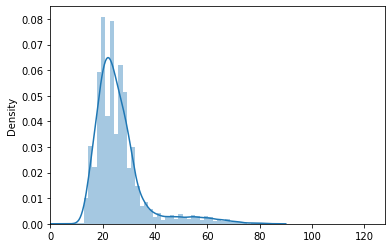

In [17]:
#plot the distribution after tokenize
token_counts = []
for _, row in train.iterrows():
    token_count = len(tokenizer.encode(
                                       row["cleaned_tweet"],
                                       max_length = 128,
                                       truncation = True
                                      )
                     )
    token_counts.append(token_count)
sns.distplot(token_counts)
plt.xlim([0, 128])

In [18]:
#most tweets contain less than 128 tokens, then stick with this number
MAX_TOKEN_COUNT = 128

In [19]:
#split the data into train set and valid set
train_df, valid_df = train_test_split(train, test_size = 0.2, random_state = 42)
print('train df has', train_df.shape[0], 'rows')
print('valid df has', valid_df.shape[0], 'rows')

train df has 6336 rows
valid df has 1584 rows


In [20]:
class MakeDataset(Dataset):
    def __init__(self, data: pd.DataFrame, tokenizer: BertTokenizer, max_token_len: int = 256):
        self.tokenizer = tokenizer
        self.data = data
        self.max_token_len = max_token_len
        self.labels = self.data['label']
    
    def __len__(self):
        return len(self.data)

    def __getitem__(self, index: int):
        data_row = self.data.iloc[index]
        cleaned_tweet = data_row['cleaned_tweet']
        labels = data_row['label']
        encoding = self.tokenizer.encode_plus(
                                              cleaned_tweet,
                                              add_special_tokens = True,
                                              max_length = self.max_token_len,
                                              return_token_type_ids = False,
                                              padding = "max_length",
                                              truncation = True,
                                              return_attention_mask = True,
                                              return_tensors = 'pt',
                                             )
        return dict(
                    cleaned_tweet = cleaned_tweet,
                    input_ids = encoding["input_ids"].flatten(),
                    attention_mask = encoding["attention_mask"].flatten(),
                    labels = labels
                   )

In [21]:
train_dataset = MakeDataset(
                            train_df,
                            tokenizer,
                            max_token_len = MAX_TOKEN_COUNT
                           )
valid_dataset = MakeDataset(
                            valid_df,
                            tokenizer,
                            max_token_len = MAX_TOKEN_COUNT
                           )

In [22]:
#see how output look like
train_dataset[987]

{'attention_mask': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0]),
 'cleaned_tweet': 'hey apple shopcrabtree you suck spent  to have a power cable last me  year and  months',
 'input_ids': tensor([    0, 12229, 15162,  2792,  8344,   873, 21512,    47, 23829,  1240,
          1437,     7,    33,    10,   476,  6129,    94,   162,  1437,    76,
             8,  1437,   377,     2,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,    

In [23]:
#define model from pretrained model
class RobertaClass(nn.Module):
    def __init__(self):
        super(RobertaClass, self).__init__()
        self.bert_model = RobertaModel.from_pretrained(model_name, return_dict = True)
        self.dropout = nn.Dropout(0.2)
        self.linear = nn.Linear(768, 1)
    
    def forward(self, input_ids, attention_mask):
        output = self.bert_model(input_ids, attention_mask)
        output_dropout = self.dropout(output.pooler_output)
        output = self.linear(output_dropout)
        output = torch.sigmoid(output)
        return output
    
model = RobertaClass()

Downloading:   0%|          | 0.00/478M [00:00<?, ?B/s]

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.bias', 'lm_head.decoder.weight', 'lm_head.dense.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [24]:
#calculate weight for imbalanced data
train_label_count = train_df['label'].value_counts().values
neg_label_count = [sum(train_label_count) - count for count in train_label_count]
pos_weights = neg_label_count/train_label_count.min()
pos_weights = torch.tensor(pos_weights)

In [25]:
#define train and validation loop
def _run(model):

    def loss_fn(outputs, labels):
        return nn.BCELoss(weight = pos_weights)(outputs, labels)
    
    def train_fn(train_dataloader, model, optimizer, scheduler, device):

        model.train()
        
        losses = []
        correct_predictions = 0

        for batch_idx, batch in enumerate(train_dataloader):
            
            input_ids = batch['input_ids'].to(device, dtype = torch.long)
            attention_mask = batch['attention_mask'].to(device, dtype = torch.long)
            labels = batch['labels'].to(device, dtype = torch.float)

            outputs = model(input_ids, attention_mask)
            
            loss = loss_fn(outputs, labels.unsqueeze(1))

            preds = (outputs > 0.5).float()
            
            correct_predictions += torch.sum(preds == labels.unsqueeze(1))
            losses.append(loss.item())

            loss.backward()
            xm.optimizer_step(optimizer)
            lr_scheduler.step()
            optimizer.zero_grad()

            acc = correct_predictions.double() / len(train_df)

            xm.master_print(f'Acc : {acc} train_loss : {np.mean(losses)}')

    def valid_fn(valid_dataloader, model, device):

        model.eval()
        global y_pred 
        global y_valid 
        y_pred = []
        y_valid = []

        losses = []
        correct_predictions = 0

        for batch_idx, batch in enumerate(valid_dataloader):

            input_ids = batch['input_ids'].to(device, dtype = torch.long)
            attention_mask = batch['attention_mask'].to(device, dtype = torch.long)
            labels = batch['labels'].to(device, dtype = torch.float)
            
            outputs = model(input_ids, attention_mask)
            
            loss = loss_fn(outputs, labels.unsqueeze(1))

            preds = (outputs > 0.5).float()
            
            correct_predictions += torch.sum(preds == labels.unsqueeze(1))
            losses.append(loss.item())

            y_pred.extend(preds.cpu().squeeze().numpy())
            y_valid.extend(labels.cpu().numpy())

            acc = correct_predictions.double() / len(valid_df)
            
            xm.master_print(f'Acc {acc} train_loss {np.mean(losses)}')
    
    EPOCHS = 10
    BATCH_SIZE = 32

    train_sampler = torch.utils.data.distributed.DistributedSampler(
                                                                    train_dataset,
                                                                    num_replicas = xm.xrt_world_size(),
                                                                    rank = xm.get_ordinal(),
                                                                    shuffle = True
                                                                   )
    valid_sampler = torch.utils.data.distributed.DistributedSampler(
                                                                    valid_dataset,
                                                                    num_replicas = xm.xrt_world_size(),
                                                                    rank = xm.get_ordinal(),
                                                                    shuffle = False
                                                                   )
    
    train_data_loader = DataLoader(
                                   train_dataset,
                                   sampler = train_sampler,
                                   batch_size = BATCH_SIZE,
                                   num_workers = 2
                                  )
    valid_data_loader = DataLoader(
                                   valid_dataset,
                                   sampler = valid_sampler,
                                   batch_size = BATCH_SIZE,
                                   num_workers = 2
                                  )
    
    device = xm.xla_device()
    model = model.to(device)

    lr = 0.4 * 2e-05 * xm.xrt_world_size()

    optimizer = torch.optim.AdamW(params = model.parameters(), lr = lr)
    num_train_steps = int(len(train_dataset) / BATCH_SIZE / xm.xrt_world_size() * EPOCHS)
    xm.master_print(f'num_train_steps = {num_train_steps}, world_size={xm.xrt_world_size()}')
    num_train_steps = int(len(train_dataset) / BATCH_SIZE * EPOCHS)
    lr_scheduler = get_linear_schedule_with_warmup(
                                                   optimizer,
                                                   num_warmup_steps = 0,
                                                   num_training_steps = num_train_steps
                                                  )

    train_begin = time.time()
    for epoch in range(EPOCHS):
        
        para_loader = pl.ParallelLoader(train_data_loader, [device])

        start = time.time()
        print('*'*15)
        print(f'EPOCH: {epoch+1}')
        print('*'*15)

        print('Training.....')
        train_fn( 
                 train_dataloader = para_loader.per_device_loader(device),
                 model = model, 
                 optimizer = optimizer,
                 scheduler = lr_scheduler,
                 device = device
                )
        
        with torch.no_grad():
            
          para_loader = pl.ParallelLoader(valid_data_loader, [device])
            
          print('Validating....')
          valid_fn( 
                 valid_dataloader = para_loader.per_device_loader(device),
                 model = model,
                 device = device
                )
        
        print(f'F1_score : {f1_score(y_valid, y_pred)}')

        print(f'Epoch completed in {(time.time() - start)/60} minutes')
    print(f'Training completed in {(time.time() - train_begin)/60} minutes')


In [26]:
# Start training processes
def _mp_fn(rank, flags):
    torch.set_default_tensor_type('torch.FloatTensor')
    a = _run(model)

FLAGS={}
xmp.spawn(_mp_fn, args = (FLAGS, ), nprocs = 1, start_method = 'fork')

num_train_steps = 1980, world_size=1
***************
EPOCH: 1
***************
Training.....
Acc : 0.002998737385496497 train_loss : 1.3464545011520386
Acc : 0.006786616053432226 train_loss : 1.3252769112586975
Acc : 0.010416666977107525 train_loss : 1.3248448371887207
Acc : 0.01499368716031313 train_loss : 1.3005661368370056
Acc : 0.018308080732822418 train_loss : 1.3022625923156739
Acc : 0.02209595963358879 train_loss : 1.2944447596867878
Acc : 0.026199495419859886 train_loss : 1.2840123176574707
Acc : 0.030145201832056046 train_loss : 1.2792903929948807
Acc : 0.03393308073282242 train_loss : 1.273453089925978
Acc : 0.03787878900766373 train_loss : 1.261142098903656
Acc : 0.041508838534355164 train_loss : 1.2550340349023992
Acc : 0.04482323303818703 train_loss : 1.2568765083948772
Acc : 0.048453282564878464 train_loss : 1.2472941692058856
Acc : 0.052241161465644836 train_loss : 1.233756763594491
Acc : 0.05602904036641121 train_loss : 1.219938071568807
Acc : 0.05950126424431801 train_l

In [27]:
class MakeTestDataset(Dataset):
    def __init__(self, data: pd.DataFrame, tokenizer: BertTokenizer, max_token_len: int = 256):
        self.tokenizer = tokenizer
        self.data = data
        self.max_token_len = max_token_len
    
    def __len__(self):
        return len(self.data)

    def __getitem__(self, index: int):
        data_row = self.data.iloc[index]
        cleaned_tweet = data_row['cleaned_tweet']
        encoding = self.tokenizer.encode_plus(
                                              cleaned_tweet,
                                              add_special_tokens = True,
                                              max_length = self.max_token_len,
                                              return_token_type_ids = False,
                                              padding = "max_length",
                                              truncation = True,
                                              return_attention_mask = True,
                                              return_tensors = 'pt',
                                             )
        return dict(
                    cleaned_tweet = cleaned_tweet,
                    input_ids = encoding["input_ids"].flatten(),
                    attention_mask = encoding["attention_mask"].flatten(),
                   )

valid_dataset = MakeTestDataset(
                               valid_df,
                               tokenizer,
                               max_token_len = MAX_TOKEN_COUNT
                              )
test_dataset = MakeTestDataset(
                               test,
                               tokenizer,
                               max_token_len = MAX_TOKEN_COUNT
                              )

valid_sampler = torch.utils.data.distributed.DistributedSampler(
                                                                valid_dataset,
                                                                num_replicas = xm.xrt_world_size(),
                                                                rank = xm.get_ordinal(),
                                                                shuffle = False
                                                               )

test_sampler = torch.utils.data.distributed.DistributedSampler(
                                                                test_dataset,
                                                                num_replicas = xm.xrt_world_size(),
                                                                rank = xm.get_ordinal(),
                                                                shuffle = False
                                                               )
BATCH_SIZE = 32
valid_data_loader = DataLoader(
                               valid_dataset,
                               sampler = valid_sampler,
                               batch_size = BATCH_SIZE,
                               num_workers = 2
                              )
test_data_loader = DataLoader(
                               test_dataset,
                               sampler = test_sampler,
                               batch_size = BATCH_SIZE,
                               num_workers = 2
                              )

In [28]:
#predict valid set
val_preds = []
model = model.eval()
with torch.no_grad():
    for batch_idx, batch in enumerate(valid_data_loader):
        input_ids = batch['input_ids'].to(device, dtype = torch.long)
        attention_mask = batch['attention_mask'].to(device, dtype = torch.long)
        outputs = model(input_ids, attention_mask)
        outputs,_ = torch.max(outputs, dim = 1)
        val_preds.extend(outputs.tolist())

Best Threshold=0.023303, G-Mean=0.924


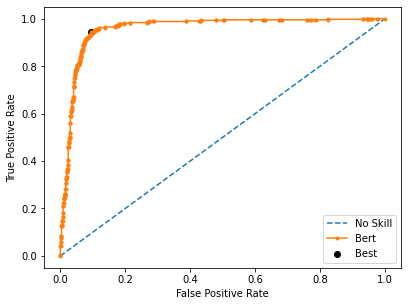

In [29]:
#plot ROC curve
fpr, tpr, thresholds = roc_curve(valid_df['label'], val_preds)

# calculate the g-mean for each threshold
gmeans = np.sqrt(tpr * (1-fpr))

# locate the index of the largest g-mean
ix = np.argmax(gmeans)
print('Best Threshold=%f, G-Mean=%.3f' % (thresholds[ix], gmeans[ix]))

# plot the roc curve for the model
plt.figure(num = 0, figsize = [6.4, 4.8])
plt.plot([0,1], [0,1], linestyle = '--', label = 'No Skill')
plt.plot(fpr, tpr, marker = '.', label = 'Bert')
plt.scatter(fpr[ix], tpr[ix], marker = 'o', color = 'black', label = 'Best')

# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()

# show the plot
plt.show()

In [30]:
val_prediction = [int(pred > thresholds[ix]) for pred in val_preds]

In [31]:
print(classification_report(valid_df['label'], val_prediction))

              precision    recall  f1-score   support

           0       0.98      0.90      0.94      1152
           1       0.79      0.94      0.86       432

    accuracy                           0.91      1584
   macro avg       0.88      0.92      0.90      1584
weighted avg       0.92      0.91      0.92      1584



In [32]:
#predict test set
preds = []
model = model.eval()
with torch.no_grad():
    for batch_idx, batch in enumerate(test_data_loader):
        input_ids = batch['input_ids'].to(device, dtype = torch.long)
        attention_mask = batch['attention_mask'].to(device, dtype = torch.long)
        outputs = model(input_ids, attention_mask)
        outputs,_ = torch.max(outputs, dim = 1)
        preds.extend(outputs.tolist())

In [33]:
prediction = [int(pred > thresholds[ix]) for pred in preds]

In [34]:
ss['label'] = prediction

In [35]:
ss['label'].value_counts()

0    1291
1     662
Name: label, dtype: int64

In [36]:
from google.colab import files
ss.to_csv('sub8.csv', index = False)
files.download('sub8.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>